<a href="https://colab.research.google.com/github/tally0818/PlayingAroundWithNATSBench/blob/main/playing_around_with_NATSBench.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring Neural Architecture Search with NATS-Bench 1

0. **Environment Setup & Dataset Preparation**
1. **Multi-Trial Search Algorithms**
2. **Zero-Cost Proxies**



## 0. Environment Setup & Dataset Preparation

In [ ]:
!git clone --recurse-submodules https://github.com/D-X-Y/AutoDL-Projects.git XAutoDL
!pip install nats_bench
!mkdir /root/.torch
%cd /root/.torch
!pip install gdown
!gdown --id 17_saCsj_krKjlCBLOJEpNtzPXArMCqxU -O NATS-tss-v1_0-3ffb9-simple.tar
!tar -xf NATS-tss-v1_0-3ffb9-simple.tar
%cd /content/XAutoDL
!pip install .

In [2]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from nats_bench import create
from xautodl.models import get_cell_based_tiny_net
bench = create("/root/.torch/NATS-tss-v1_0-3ffb9-simple", 'tss', fast_mode=True, verbose = False)

## 1. Multi-Trial NAS: Reinforcement, Regularized EA, Random Search

The basic idea of Neural Architecture Search (NAS) is to find the best architecture within a predefined **search space** by following a specific **search strategy**.

**Multi-trial algorithms** were proposed in the early days of NAS. These algorithms essentially train many architectures and select the best-performing one.

Despite their theoretical simplicity, they are still widely used as standard benchmarks in many research studies.

In [ ]:
!python ./exps/NATS-algos/reinforce.py       --dataset cifar100 --search_space tss --learning_rate 0.01
!python ./exps/NATS-algos/regularized_ea.py  --dataset cifar100 --search_space tss --ea_cycles 200 --ea_population 10 --ea_sample_size 3
!python ./exps/NATS-algos/random_wo_share.py --dataset cifar100 --search_space tss

In [4]:
methods = {
    "REINFORCE": "/content/XAutoDL/output/search-tss/cifar100-T20000/REINFORCE-0.01/results.pth",
    "R-EA": "/content/XAutoDL/output/search-tss/cifar100-T20000/R-EA-SS3/results.pth",
    "Random": "/content/XAutoDL/output/search-tss/cifar100-T20000/RANDOM/results.pth",
}

### Accuracy and Loss Visualization

In [5]:
def VisualizeByMetric(methods, metric):
  num_methods = len(methods.keys())
  all_data = []
  for method_num in range(num_methods):
    key = list(methods.keys())[method_num]
    data = torch.load(methods[key])

    for search_idx in range(len(data)):
      search = data[search_idx]
      for hp in range(len(search["all_archs"])):
        value = bench.get_more_info(search["all_archs"][hp], "cifar100", hp="200")[metric]
        all_data.append({"Epoch": hp,
                         "Metric": value,
                         "Method": key,
                         "Search ID": search_idx
                         })

  df = pd.DataFrame(all_data)
  plt.figure(figsize=(10, 6))
  sns.lineplot(data=df, x="Epoch", y="Metric", hue="Method", alpha=0.3)
  plt.title(metric + " over Epochs")
  plt.xlabel("Epoch")
  plt.ylabel("Test Accuracy")
  plt.legend(title="Method")
  plt.show()

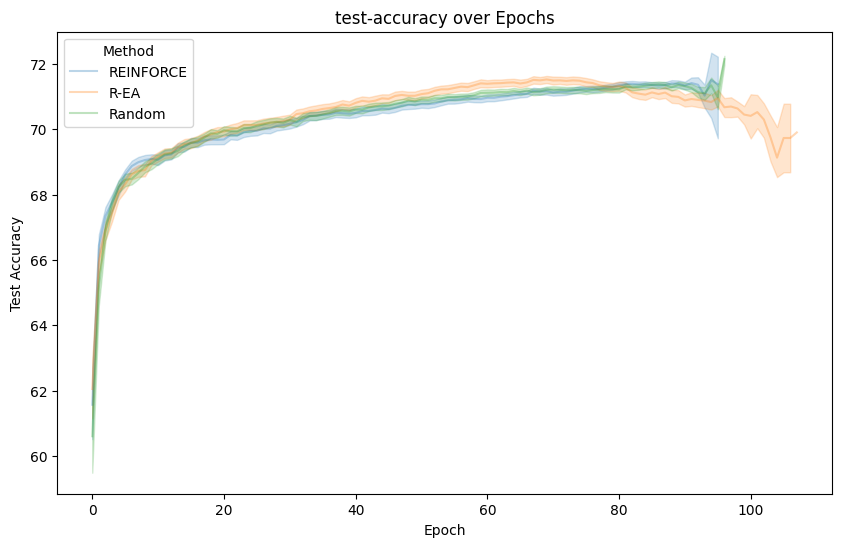

In [6]:
VisualizeByMetric(methods, 'test-accuracy')

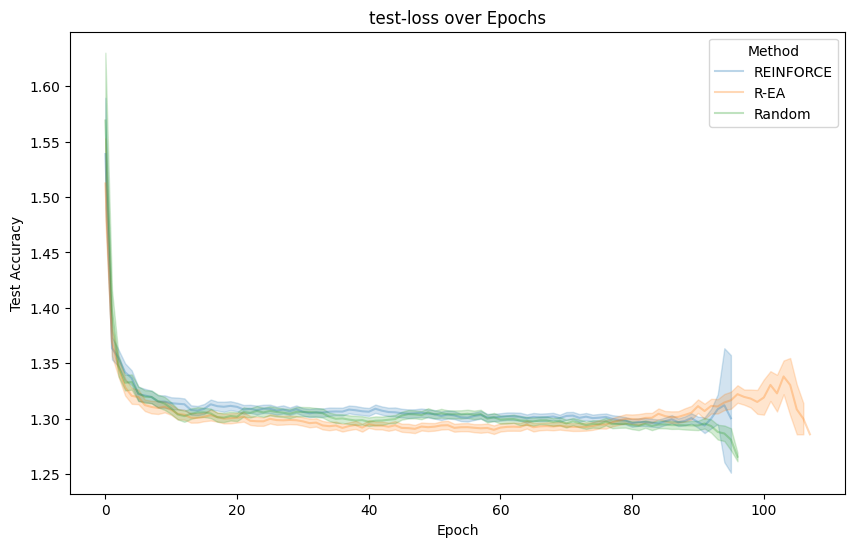

In [7]:
VisualizeByMetric(methods, 'test-loss')

As is well known, the **regularized evolution** algorithm outperforms both **random search** and **reinforcement learning-based search**.

From here on, we will explore the reasons behind this result by analyzing the **operation preferences** of each algorithm.

### Operation Distribution in Top Architectures

In [8]:
def analyze_architecture(data):
  op_counts = defaultdict(int)
  total_ops = 0
  for search_idx in range(len(data)):
    search = data[search_idx]
    print(search)
    structure = bench.get_net_config(search["all_archs"][-1], "cifar100")["arch_str"]
    test_acc = bench.get_more_info(search["all_archs"][-1], "cifar100", hp="200")["test-accuracy"]
    if test_acc >= 70:
      operations = structure.split("+")
      for op in operations:
        op_name = op.split("~")[0].strip("|")
        op_counts[op_name] += 1
        total_ops += 1
  op_ratios = {}
  if total_ops > 0:
    for op_name, count in op_counts.items():
      op_ratios[op_name] = count / total_ops * 100

  return op_ratios

{'all_archs': [10955, 15221, 15221, 15221, 15221, 15221, 15221, 15221, 15221, 15221, 15221, 15221, 15221, 15221, 15221, 15221, 15221, 15221, 15221, 15221, 15221, 15221, 15221, 15221, 15221, 15221, 15221, 15221, 15221, 15221, 15221, 15221, 15221, 15221, 15221, 15221, 15221, 15221, 15221, 15221, 15221, 15221, 15221, 15221, 15221, 15221, 15221, 15221, 15221, 15221, 15221, 15221, 15221, 15221, 15221, 15221, 15221, 8610, 8610, 8610, 8610, 3456, 3456, 3456, 3456, 3456, 3456, 3456, 3456, 3456, 3456, 3456, 3456, 3456, 3456, 3456, 3456, 3456, 3456, 3456, 3456, 3456, 3456, 3456, 3456, 3456, 3456, 3456, 3456, 3456, 3456], 'all_total_times': [257.57820462329045, 504.99806930337627, 771.535938492843, 952.9978227047692, 1182.3063449206807, 1425.8392161925633, 1621.8957282929193, 1787.1610949465207, 2047.4693216284118, 2305.987720146066, 2556.1955008847376, 2847.414652188619, 3205.4835375235193, 3411.156044591041, 3686.558575726691, 3988.3788297829174, 4222.380055123851, 4304.847386868227, 4579.83474

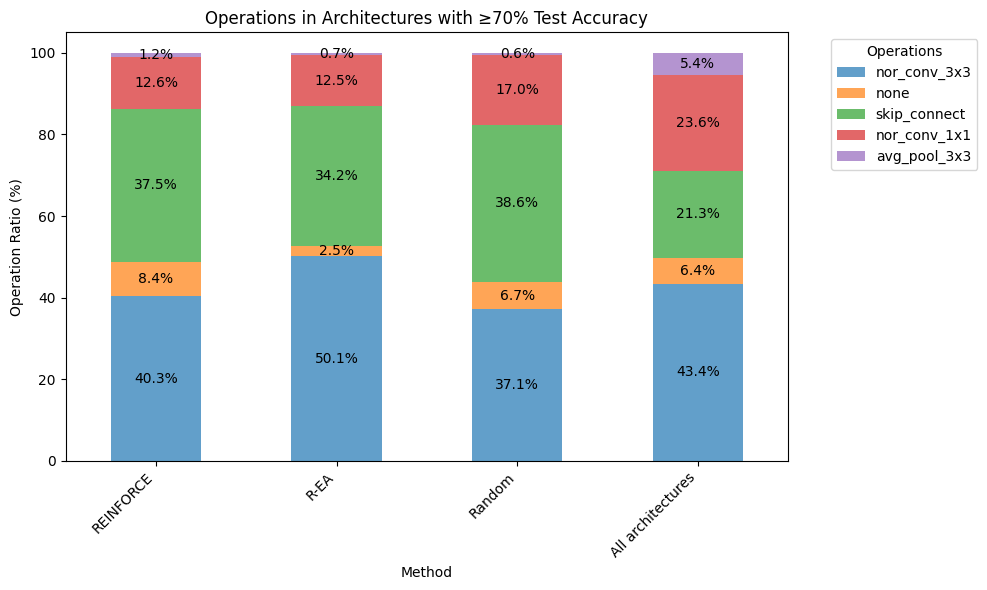

In [9]:
all_op_ratios = {}
for method, path in methods.items():
  data = torch.load(path)
  all_op_ratios[method] = analyze_architecture(data)

op_counts = defaultdict(int)
total_ops = 0
for search_idx in range(len(bench)):
  test_acc = bench.get_more_info(search_idx, "cifar100", hp="200")["test-accuracy"]
  if test_acc >= 70:
    operations = bench[search_idx].split("+")
    for op in operations:
      op_name = op.split("~")[0].strip("|")
      op_counts[op_name] += 1
      total_ops += 1
op_ratios = {}
if total_ops > 0:
  for op_name, count in op_counts.items():
    op_ratios[op_name] = count / total_ops * 100
all_op_ratios["All architectures"] = op_ratios


df = pd.DataFrame(all_op_ratios).T.fillna(0)

ax = df.plot(kind='bar', stacked=True, figsize=(10, 6), alpha=0.7)
plt.title("Operations in Architectures with ≥70% Test Accuracy")
plt.xlabel("Method")
plt.ylabel("Operation Ratio (%)")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Operations", bbox_to_anchor=(1.05, 1), loc='upper left')
for container in ax.containers:
  ax.bar_label(container, fmt='%.1f%%', label_type='center')
plt.tight_layout()
plt.show()

All three algorithms tend to prefer **skip connections** and tend not to prefer **average pooling**.

It is believed that the **regularized evolution algorithm** achieved better performance than the others due to its preference for the **3x3 convolution** operation.

## 2. Zero-Cost Proxies

The main drawback of **multi-trial algorithms** is that the architecture must be trained to evaluate its performance, which is **computationally expensive**.

To address this issue, **zero-cost proxies** have been proposed to **roughly estimate the performance** of an architecture **without training it**

In [10]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from scipy.stats import spearmanr
import numpy as np

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4687,0.4408), (0.2675, 0.2565, 0.2761))
])
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=96, shuffle=True)
testloader = DataLoader(testset, batch_size=96, shuffle=False)


100%|██████████| 169M/169M [00:13<00:00, 12.9MB/s]


In [11]:
class Proxy:
  def estimate(self, model: torch.nn.Module) -> float:
    return 0

In [12]:
class SynFlow(Proxy):
  def __init__(self, train_loader, test_loader):
    self.train_loader = train_loader
    self.test_loader = test_loader
    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  def _set_weights_to_positive(self, model):
    for param in model.parameters():
      if param.requires_grad:
        param.data = torch.abs(param.data)

  def _setup_dummy_input(self, model):
    for batch in self.train_loader:
      x = batch[0] if isinstance(batch, (tuple, list)) else batch
      return torch.ones_like(x, device=self.device)

  def estimate(self, model: torch.nn.Module) -> float:
    model.eval()
    model = model.to(self.device)
    original_weights = {name: param.data.clone() for name, param in model.named_parameters() if param.requires_grad}
    self._set_weights_to_positive(model)
    dummy_input = self._setup_dummy_input(model)
    output = model(dummy_input)
    loss = output[1].sum() #(logit, output = classifier(logit))
    model.zero_grad()
    loss.backward()
    score = sum((param * param.grad).sum().item() for param in model.parameters() if param.grad is not None)
    for name, param in model.named_parameters():
      if param.requires_grad:
        param.data = original_weights[name]
    return score

In [13]:
class Snip(Proxy):
  def __init__(self, train_loader, test_loader):
    self.train_loader = train_loader
    self.test_loader = test_loader
    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  def estimate(self, model: torch.nn.Module) -> float:
    model.eval()
    model = model.to(self.device)
    original_weights = {name: param.data.clone() for name, param in model.named_parameters() if param.requires_grad}
    for batch in self.train_loader:
      x, y = batch if isinstance(batch, (tuple, list)) else (batch, None)
      x, y = x.to(self.device), y.to(self.device)
      break
    output = model(x)[1]
    loss = torch.nn.CrossEntropyLoss()(output, y)
    model.zero_grad()
    loss.backward()
    score = sum((param * param.grad).sum().abs().item() for param in model.parameters() if param.grad is not None)
    for name, param in model.named_parameters():
      if param.requires_grad:
        param.data = original_weights[name]
    return score

*Synflow vs SNIP*

||Synflow|SNIP|
|:----------:|:----------:|:----------:|
|Dataset|Independent|Dependent|
|Uses loss function?|No|Yes|
|Task|Independant|Specific|

In [14]:
def get_model(bench, id, dataset):
  config = bench.get_net_config(id, dataset)
  model = get_cell_based_tiny_net(config)
  return model

In [15]:
def get_score(model, metric: Proxy):
  return metric.estimate(model)

In [16]:
synflow = SynFlow(trainloader, testloader)
snip = Snip(trainloader, testloader)

In [17]:
test_accs, synflows, snips = [], [], []
for arch_idx in range(100):
  model = get_model(bench, arch_idx, 'cifar100')
  synflow_score = get_score(model, synflow)
  snip_score = get_score(model, snip)
  test_acc = bench.get_more_info(arch_idx, 'cifar100')['test-accuracy']
  if np.isfinite(synflow_score):
    synflows.append(synflow_score)
    snips.append(snip_score)
    test_accs.append(test_acc)

### Correlation between Proxy Scores and Accuracy

In [18]:
correlation, p_value = spearmanr(test_accs, synflows)
print(f"Spearman correlation (test accuracy vs. SynFlow): {correlation:.4f} (p={p_value:.4e})")

correlation, p_value = spearmanr(test_accs, snips)
print(f"Spearman correlation (test accuracy vs. Snip): {correlation:.4f} (p={p_value:.4e})")

Spearman correlation (test accuracy vs. SynFlow): 0.5151 (p=7.9128e-08)
Spearman correlation (test accuracy vs. Snip): -0.1968 (p=5.4617e-02)


It can be observed that the **SynFlow proxy** is highly correlated with the performance of the architecture.

On the other hand, the **SNIP proxy** shows only a weak correlation and was found to be **statistically insignifican**t in this context.

### Operator Analysis for Top Architectures by Proxy Scores

In [19]:
def get_operation_list(bench, arch_index):
    arch_info = bench.get_net_config(arch_index, 'cifar100')
    return [part.split('~')[0].strip() for op in arch_info['arch_str'].split('|') for part in op.split('~') if part.strip() and part.strip() != '0']

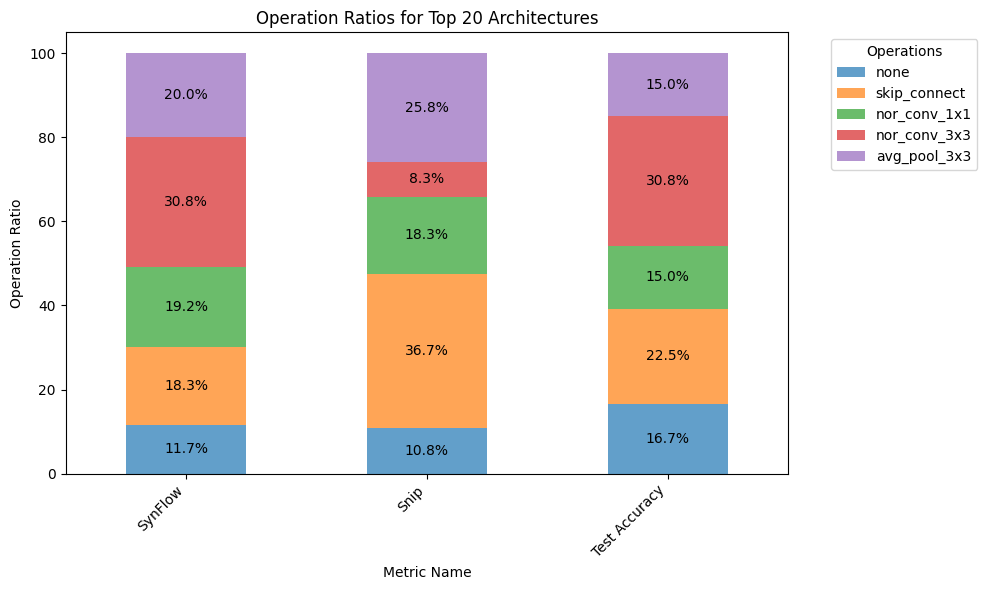

In [20]:
ops_list = ['none', 'skip_connect', 'nor_conv_1x1', 'nor_conv_3x3', 'avg_pool_3x3']
topk = 20
results = {}
for (metric_name, scores) in [("SynFlow", synflows), ("Snip", snips),("Test Accuracy", test_accs)]:
    score_idx_pairs = sorted([[score, i] for i, score in enumerate(scores)], reverse=True)
    top_arch_indices = [idx for _, idx in score_idx_pairs[:topk]]
    op_counts = {op: 0 for op in ops_list}
    for idx in top_arch_indices:
        arch_str = bench.arch(idx)
        for op in ops_list:
            op_counts[op] += arch_str.count(op) * 100 / 120
    results[metric_name] = op_counts

df = pd.DataFrame(results).T
ax = df.plot(kind='bar', stacked=True, figsize=(10, 6), alpha=0.7)
plt.title('Operation Ratios for Top 20 Architectures')
plt.xlabel('Metric Name')
plt.ylabel('Operation Ratio')
plt.xticks(rotation=45, ha='right')
plt.legend(title="Operations", bbox_to_anchor=(1.05, 1), loc='upper left')
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='center')
plt.tight_layout()
plt.show()


Unlike the **SynFlow proxy**, the **SNIP proxy** tends to assign relatively higher scores to architectures with a large number of **skip connections** and **3x3 average pooling operations**.

## 3. References|

[NATS-Bench: Benchmarking NAS Algorithms for Architecture Topology and Size](https://arxiv.org/abs/2009.00437)

[NEURAL ARCHITECTURE SEARCH WITH REINFORCEMENT LEARNING](https://arxiv.org/pdf/1611.01578)

[Learning Transferable Architectures for Scalable Image Recognition](https://arxiv.org/pdf/1707.07012)

[Neural Architecture Search: Insights from 1000 Papers](https://arxiv.org/pdf/2301.08727)

[Regularized Evolution for Image Classifier Architecture Search](https://arxiv.org/pdf/1802.01548)

[Proximal Policy Optimization Algorithms](https://arxiv.org/pdf/1707.06347)

[Zero-Cost Proxies for Lightweight NAS](https://arxiv.org/abs/2101.08134)

[Pruning neural networks without any data by iteratively conserving synaptic flow](https://arxiv.org/abs/2006.05467)

[SNIP: Single-shot Network Pruning based on Connection Sensitivity](https://arxiv.org/abs/1810.02340)